# Full waveform Inversion (FWI) on the Marmousi model with Deepwave (PyTorch)

This notebook implements a 2‑D **acoustic** Full Waveform Inversion (FWI) experiment on the **Marmousi** P‑wave velocity model using **Deepwave** for wave propagation and **PyTorch automatic differentiation** for gradient computation.

**Inputs**
- A binary file `marmousi_vp.bin` containing the Marmousi P‑wave velocity (Vp) in **m/s**, stored as `float32`.

**Outputs**
- Synthetic “observed” data generated from the true model
- Observed and inverted velocity models after iterative optimization
- Diagnostic plots (models, shot gathers, residuals, loss curve)
- Shot‑by‑shot error metrics at the end of the notebook


In [1]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 13.9 MB/s eta 0:00:00


In [2]:
# This is to change .mat file to .bin file
# Install required library
!pip install scipy

import scipy.io
import numpy as np
import os

# --- Configure these ---
mat_file = 'anticline_model.mat'     # your .mat filename
dtype_out = np.float32     # change to type your binary reader expects
# -------------------------

# Load .mat file
mat_data = scipy.io.loadmat(mat_file)

# Create output directory
out_dir = "bin_output"
os.makedirs(out_dir, exist_ok=True)

converted = []

for key, value in mat_data.items():
    # Skip built-in MATLAB metadata fields
    if key.startswith('__'):
        continue

    # Only convert numeric numpy arrays
    if isinstance(value, np.ndarray) and value.dtype != object:
        # Flatten the array if needed (optional — comment out if your code expects original shape)
        flat = value.flatten()

        # Write binary file
        out_path = os.path.join(out_dir, f"{key}.bin")
        with open(out_path, "wb") as f:
            f.write(flat.astype(dtype_out).tobytes())

        converted.append((key, out_path, flat.shape))
    else:
        print(f"Skipping non-numeric or unsupported variable: '{key}'")

# Summary
print("Conversion complete!")
for name, path, shape in converted:
    print(f"  {name} → {path}, shape={shape}, type={dtype_out}")


Conversion complete!
  dx → bin_output/dx.bin, shape=(1,), type=<class 'numpy.float32'>
  dz → bin_output/dz.bin, shape=(1,), type=<class 'numpy.float32'>
  fmat → bin_output/fmat.bin, shape=(343400,), type=<class 'numpy.float32'>


In [3]:
# LIBRARIES AND SETTINGS
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

import deepwave
from deepwave import scalar           # 2-D acoustic wave propagation

# Device: GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# INPUT: MAMRMOUSI Vp BINARY FILE
vp_path = 'marmousi_vp.bin'   # Insert the path to the Marmousi velocity model here
nx0, nz0 = 2301, 751          # Original Marmousi grid size (x, z)

vp = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0).to(device)

# PREPROCESSING: SMOOTH AND SUBSAMPLE TO REDUCE COMPUTATIONAL COST
factor = 5   # smoothing + subsampling factor

vp_np = vp.detach().cpu().numpy()
vp_smooth = gaussian_filter(vp_np, sigma=factor)

vp_reduced = vp_smooth[::factor, ::factor]
nx, nz = vp_reduced.shape               # New dimensions

# Original grid spacing is 4 m in Marmousi; after subsampling:
dx = 4.0 * factor  # meters
dz = 4.0 * factor  # meters
spacing = (dx, dz)

# Extent for imshow after plotting the velocity models
x_max = (nx - 1) * dx
z_max = (nz - 1) * dz
extent = [0, x_max, z_max, 0]

# TRUE VELOCITY MODEL (m/s)
v_true = torch.from_numpy(vp_reduced).to(device)

# INITIAL VELOCITY MODEL - smooth *slowness* then invert back to velocity
v_init = (torch.tensor(1/gaussian_filter(1/v_true.cpu(), 25))
          .to(device))

# Variable updated during inversion
v1 = v_init.clone()

print(f"Model shape (nx, nz) = {tuple(v_true.shape)}, dx=dz={dx:.1f} m")
print(f"Velocity range (true): {v_true.min().item():.1f}–{v_true.max().item():.1f} m/s")
print(f"Velocity range (init): {v_init.min().item():.1f}–{v_init.max().item():.1f} m/s")

Device: cuda
Model shape (nx, nz) = (461, 151), dx=dz=20.0 m
Velocity range (true): 1503.7–5500.0 m/s
Velocity range (init): 1718.7–3966.8 m/s


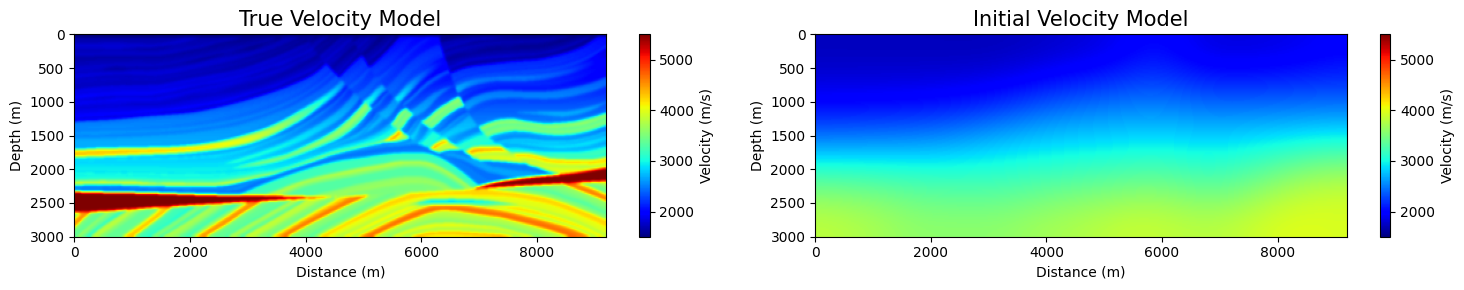

In [4]:
# PLOTTRUE AND INITIAL VELOCITY MODELS
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
im1 = ax1.imshow(v_true.cpu().T, cmap='jet', aspect='auto', vmin=v_true.min(), vmax=v_true.max(), extent=extent)
ax1.set_title('True Velocity Model', fontsize = 15)
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Depth (m)')

im2 = ax2.imshow(v_init.cpu().T, cmap='jet', aspect='auto', vmin=v_true.min(), vmax=v_true.max(), extent=extent)
ax2.set_title('Initial Velocity Model', fontsize =15)
ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('Depth (m)')

fig1.colorbar(im1, ax=ax1, label='Velocity (m/s)')
fig1.colorbar(im2, ax=ax2, label='Velocity (m/s)')


plt.tight_layout()
plt.show()

In [5]:
# ACQUISITION GEOMETRY AND FORWARD MODELLING

# SOURCES
n_shots = 10
n_sources_per_shot = 1
source_depth = 1              # grid index in z

# RECEIVERS
n_receivers_per_shot = 93
receiver_depth = 1            # grid index in z

# PARAMETERS OF THE WAVELET
freq = 5                 # Frequency of the wavelet in Hz
nt = 1350                # Number of time samples
dt = 0.004               # Sampling interval in seconds
peak_time = 1.5/freq

# SOURCE LOCATIONS
source_loc = torch.zeros(n_shots, n_sources_per_shot, 2,
                         dtype = torch.long, device = device)
source_loc[..., 1] = source_depth
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).round()

# RECEIVERS LOCATIONS
receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = receiver_depth
receiver_loc[:, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).round()


# SOURCE AMPLITUDES - RICKER WAVELET - 5 Hz
source_amp = (
            deepwave.wavelets.ricker(freq, nt, dt, peak_time)
            .repeat(n_shots, n_sources_per_shot, 1)
            .to(device)
            )

# FORWARD MODELLING FOR THE ACOUSTIC WAVE EQUATION
out_obs = scalar(v_true, spacing, dt, source_amplitudes= source_amp,
                 source_locations= source_loc, receiver_locations= receiver_loc,
                 accuracy=4, pml_freq= freq)

observed_data = out_obs[-1]  # located in the last tensor of the output of the forward model

print("Observed data shape:", tuple(observed_data.shape))

Observed data shape: (10, 93, 1350)


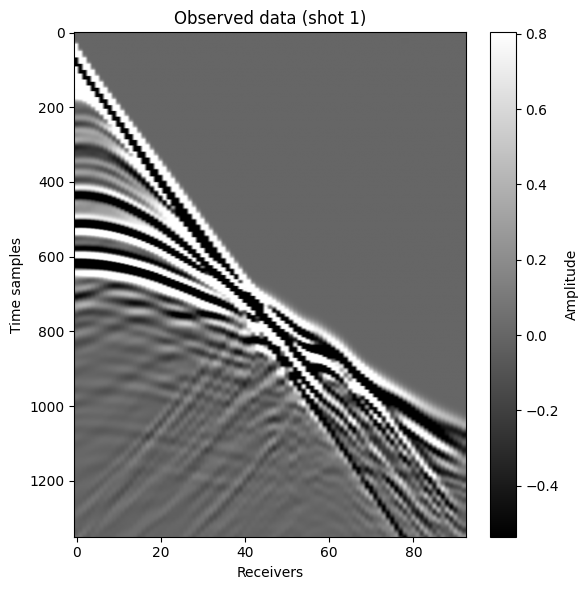

In [6]:
# PLOT OBSERVED DATA FOR ONE SHOT
shot_idx = 0    # Select the shot to be plotted

obs = observed_data[shot_idx].cpu()
amin, amax = torch.quantile(observed_data[shot_idx],
                            torch.tensor([0.05, 0.95]).to(device))
plt.figure(figsize=(6, 6))
plt.imshow(obs.T, cmap='gray', aspect='auto', vmin=amin, vmax=amax)
plt.xlabel('Receivers') ; plt.ylabel('Time samples')
plt.colorbar(label='Amplitude')
plt.title(f'Observed data (shot {shot_idx + 1})')
plt.tight_layout()

#plt.savefig('observed_data_shot_1.png', dpi = 300)  # uncomment this line to save the observed data

plt.show()

In [7]:
# COSINE TAPER TO REDUCE TEH EDGE EFFECTS ON TRACES
# The taper length (n_taper) is in samples (applied at the end of each trace)
def taper(x, n_taper = 5):
    return deepwave.common.cosine_taper_end(x, n_taper)

# TAPER THE OBSERVED DATA
observed_data_tapered = taper(observed_data, n_taper = 5)

# SET THE LOSS FUNCTION
loss_fn = torch.nn.MSELoss()


Epoch 1: loss=5.52157, v_min=1618.9, v_max=3994.1
Epoch 2: loss=3.10466, v_min=1524.4, v_max=4034.5
Epoch 3: loss=1.95810, v_min=1480.0, v_max=4065.2
Epoch 4: loss=1.35556, v_min=1480.0, v_max=4107.8
Epoch 5: loss=1.04094, v_min=1480.0, v_max=4145.9
Epoch 6: loss=0.88521, v_min=1480.0, v_max=4178.8
Epoch 7: loss=0.85562, v_min=1480.0, v_max=4205.5
Epoch 8: loss=0.85432, v_min=1480.0, v_max=4225.5
Epoch 9: loss=0.84060, v_min=1480.0, v_max=4239.4
Epoch 10: loss=0.82041, v_min=1480.0, v_max=4247.5
Epoch 11: loss=0.80228, v_min=1480.0, v_max=4251.0
Epoch 12: loss=0.78292, v_min=1480.0, v_max=4276.7
Epoch 13: loss=0.76496, v_min=1480.0, v_max=4326.0
Epoch 14: loss=0.74744, v_min=1480.0, v_max=4373.1
Epoch 15: loss=0.72710, v_min=1480.0, v_max=4418.7
Epoch 16: loss=0.70696, v_min=1480.0, v_max=4463.2
Epoch 17: loss=0.68672, v_min=1480.0, v_max=4506.7
Epoch 18: loss=0.66634, v_min=1480.0, v_max=4549.2
Epoch 19: loss=0.64594, v_min=1480.0, v_max=4590.4
Epoch 20: loss=0.62261, v_min=1480.0, v_

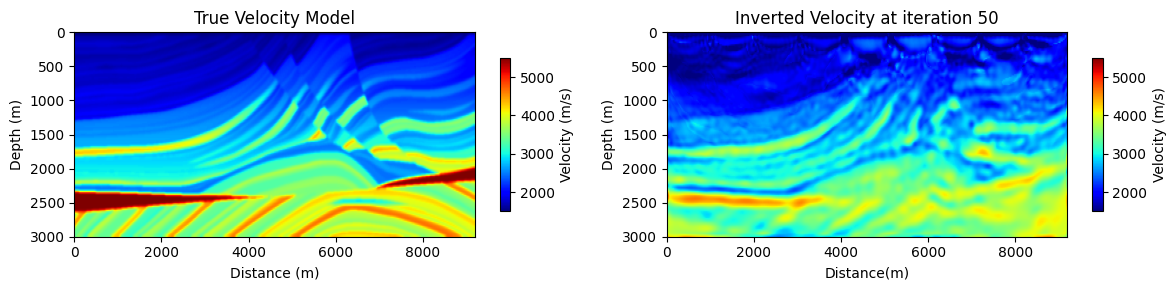

Epoch 51: loss=0.16718, v_min=1480.0, v_max=5102.8
Epoch 52: loss=0.15855, v_min=1480.0, v_max=5107.5
Epoch 53: loss=0.15014, v_min=1480.0, v_max=5112.2
Epoch 54: loss=0.14177, v_min=1480.0, v_max=5116.5
Epoch 55: loss=0.13341, v_min=1480.0, v_max=5120.5
Epoch 56: loss=0.12542, v_min=1480.0, v_max=5124.0
Epoch 57: loss=0.11771, v_min=1480.0, v_max=5127.1
Epoch 58: loss=0.11013, v_min=1480.0, v_max=5129.8
Epoch 59: loss=0.10271, v_min=1480.0, v_max=5132.0
Epoch 60: loss=0.09576, v_min=1480.0, v_max=5133.8
Epoch 61: loss=0.08919, v_min=1480.0, v_max=5135.3
Epoch 62: loss=0.08299, v_min=1480.0, v_max=5136.5
Epoch 63: loss=0.07716, v_min=1480.0, v_max=5137.4
Epoch 64: loss=0.07165, v_min=1480.0, v_max=5138.3
Epoch 65: loss=0.06644, v_min=1480.0, v_max=5139.1
Epoch 66: loss=0.06154, v_min=1480.0, v_max=5140.1
Epoch 67: loss=0.05690, v_min=1480.0, v_max=5141.3
Epoch 68: loss=0.05265, v_min=1480.0, v_max=5142.7
Epoch 69: loss=0.04874, v_min=1480.0, v_max=5144.3
Epoch 70: loss=0.04516, v_min=1

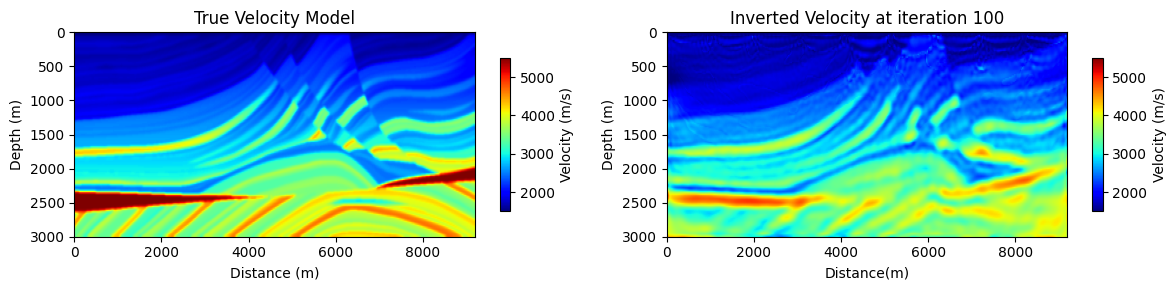

Epoch 101: loss=0.00892, v_min=1480.0, v_max=5166.7
Epoch 102: loss=0.00866, v_min=1480.0, v_max=5166.5
Epoch 103: loss=0.00819, v_min=1480.0, v_max=5166.4
Epoch 104: loss=0.00798, v_min=1480.0, v_max=5166.3
Epoch 105: loss=0.00757, v_min=1480.0, v_max=5166.3
Epoch 106: loss=0.00735, v_min=1480.0, v_max=5166.3
Epoch 107: loss=0.00704, v_min=1480.0, v_max=5166.3
Epoch 108: loss=0.00678, v_min=1480.0, v_max=5166.4
Epoch 109: loss=0.00656, v_min=1480.0, v_max=5166.6
Epoch 110: loss=0.00627, v_min=1480.0, v_max=5166.7
Epoch 111: loss=0.00610, v_min=1480.0, v_max=5166.9
Epoch 112: loss=0.00584, v_min=1480.0, v_max=5167.2
Epoch 113: loss=0.00568, v_min=1480.0, v_max=5167.5
Epoch 114: loss=0.00548, v_min=1480.0, v_max=5167.8
Epoch 115: loss=0.00530, v_min=1480.0, v_max=5168.1
Epoch 116: loss=0.00515, v_min=1480.0, v_max=5168.4
Epoch 117: loss=0.00496, v_min=1480.0, v_max=5168.7
Epoch 118: loss=0.00483, v_min=1480.0, v_max=5169.0
Epoch 119: loss=0.00467, v_min=1480.0, v_max=5169.3
Epoch 120: l

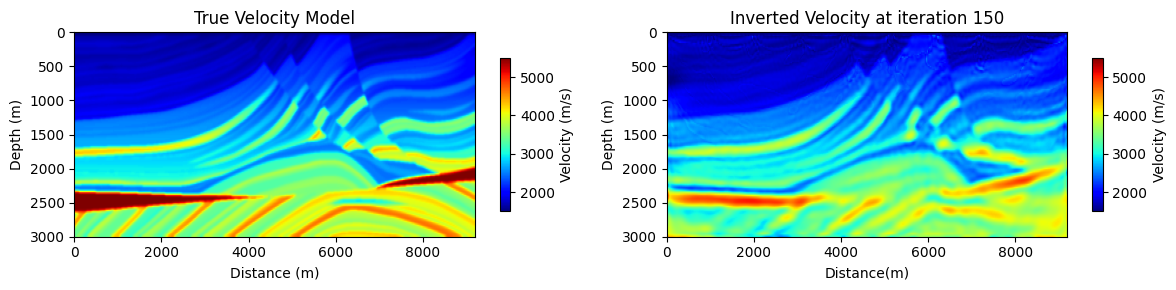

Epoch 151: loss=0.00238, v_min=1480.0, v_max=5169.1
Epoch 152: loss=0.00235, v_min=1480.0, v_max=5168.8
Epoch 153: loss=0.00231, v_min=1480.0, v_max=5168.4
Epoch 154: loss=0.00228, v_min=1480.0, v_max=5168.1
Epoch 155: loss=0.00225, v_min=1480.0, v_max=5167.7
Epoch 156: loss=0.00222, v_min=1480.0, v_max=5167.3
Epoch 157: loss=0.00219, v_min=1480.0, v_max=5166.9
Epoch 158: loss=0.00217, v_min=1480.0, v_max=5166.5
Epoch 159: loss=0.00214, v_min=1480.0, v_max=5166.1
Epoch 160: loss=0.00211, v_min=1480.0, v_max=5165.7
Epoch 161: loss=0.00209, v_min=1480.0, v_max=5165.3
Epoch 162: loss=0.00206, v_min=1480.0, v_max=5164.8
Epoch 163: loss=0.00204, v_min=1480.0, v_max=5164.4
Epoch 164: loss=0.00201, v_min=1480.0, v_max=5163.9
Epoch 165: loss=0.00199, v_min=1480.0, v_max=5163.5
Epoch 166: loss=0.00197, v_min=1480.0, v_max=5163.0
Epoch 167: loss=0.00195, v_min=1480.0, v_max=5162.5
Epoch 168: loss=0.00192, v_min=1480.0, v_max=5162.0
Epoch 169: loss=0.00190, v_min=1480.0, v_max=5161.5
Epoch 170: l

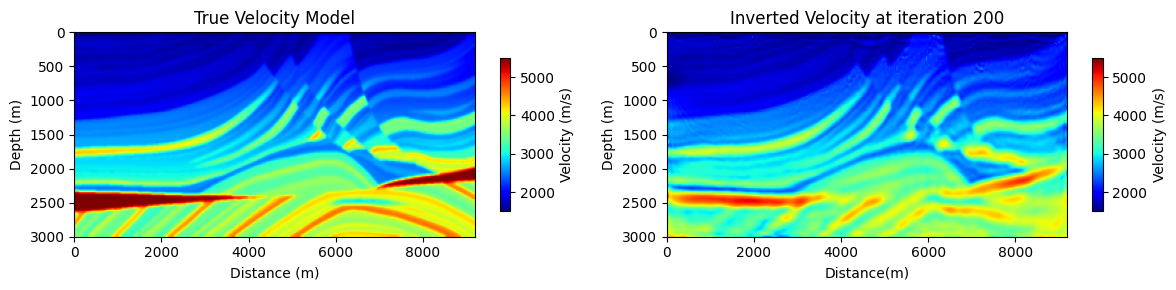

Epoch 201: loss=0.00143, v_min=1480.0, v_max=5142.6
Epoch 202: loss=0.00142, v_min=1480.0, v_max=5143.3
Epoch 203: loss=0.00141, v_min=1480.0, v_max=5144.7
Epoch 204: loss=0.00140, v_min=1480.0, v_max=5146.2
Epoch 205: loss=0.00139, v_min=1480.0, v_max=5147.6
Epoch 206: loss=0.00138, v_min=1480.0, v_max=5149.0
Epoch 207: loss=0.00137, v_min=1480.0, v_max=5150.3
Epoch 208: loss=0.00136, v_min=1480.0, v_max=5151.7
Epoch 209: loss=0.00135, v_min=1480.0, v_max=5153.1
Epoch 210: loss=0.00134, v_min=1480.0, v_max=5154.5
Epoch 211: loss=0.00133, v_min=1480.0, v_max=5155.8
Epoch 212: loss=0.00132, v_min=1480.0, v_max=5157.2
Epoch 213: loss=0.00131, v_min=1480.0, v_max=5158.5
Epoch 214: loss=0.00130, v_min=1480.0, v_max=5159.8
Epoch 215: loss=0.00129, v_min=1480.0, v_max=5161.2
Epoch 216: loss=0.00128, v_min=1480.0, v_max=5162.5
Epoch 217: loss=0.00127, v_min=1480.0, v_max=5163.8
Epoch 218: loss=0.00126, v_min=1480.0, v_max=5165.1
Epoch 219: loss=0.00125, v_min=1480.0, v_max=5166.4
Epoch 220: l

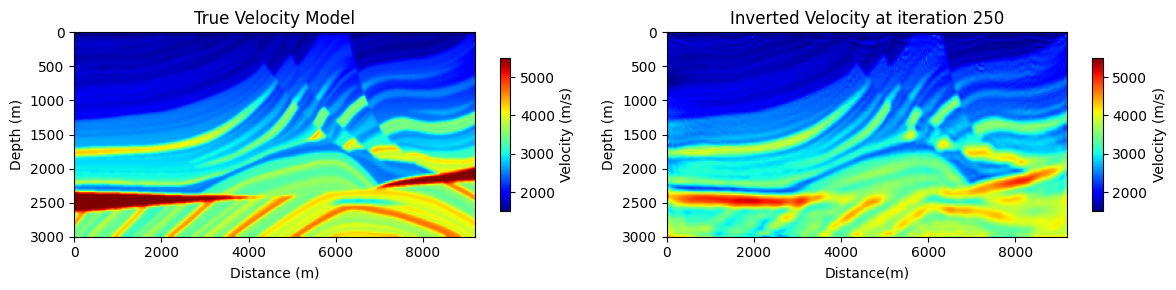

Epoch 251: loss=0.00101, v_min=1480.0, v_max=5204.9
Epoch 252: loss=0.00101, v_min=1480.0, v_max=5206.0
Epoch 253: loss=0.00100, v_min=1480.0, v_max=5207.1
Epoch 254: loss=0.00100, v_min=1480.0, v_max=5208.2
Epoch 255: loss=0.00099, v_min=1480.0, v_max=5209.3
Epoch 256: loss=0.00098, v_min=1480.0, v_max=5210.3
Epoch 257: loss=0.00098, v_min=1480.0, v_max=5211.4
Epoch 258: loss=0.00097, v_min=1480.0, v_max=5212.5
Epoch 259: loss=0.00097, v_min=1480.0, v_max=5213.6
Epoch 260: loss=0.00096, v_min=1480.0, v_max=5214.6
Epoch 261: loss=0.00095, v_min=1480.0, v_max=5215.7
Epoch 262: loss=0.00095, v_min=1480.0, v_max=5216.7
Epoch 263: loss=0.00094, v_min=1480.0, v_max=5217.8
Epoch 264: loss=0.00094, v_min=1480.0, v_max=5218.8
Epoch 265: loss=0.00093, v_min=1480.0, v_max=5219.9
Epoch 266: loss=0.00093, v_min=1480.0, v_max=5220.9
Epoch 267: loss=0.00092, v_min=1480.0, v_max=5222.0
Epoch 268: loss=0.00092, v_min=1480.0, v_max=5223.0
Epoch 269: loss=0.00091, v_min=1480.0, v_max=5224.1
Epoch 270: l

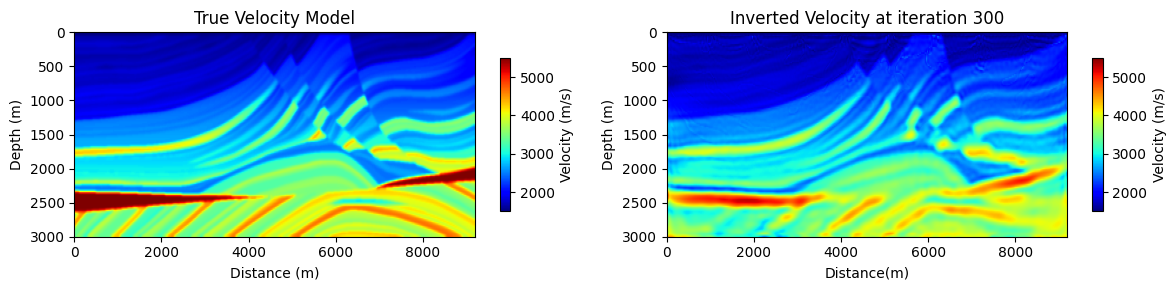

Epoch 301: loss=0.00077, v_min=1480.0, v_max=5254.5
Epoch 302: loss=0.00077, v_min=1480.0, v_max=5254.9
Epoch 303: loss=0.00077, v_min=1480.0, v_max=5255.4
Epoch 304: loss=0.00076, v_min=1480.0, v_max=5255.8
Epoch 305: loss=0.00076, v_min=1480.0, v_max=5256.3
Epoch 306: loss=0.00076, v_min=1480.0, v_max=5256.7
Epoch 307: loss=0.00076, v_min=1480.0, v_max=5257.1
Epoch 308: loss=0.00076, v_min=1480.0, v_max=5257.6
Epoch 309: loss=0.00075, v_min=1480.0, v_max=5258.0
Epoch 310: loss=0.00075, v_min=1480.0, v_max=5258.5
Epoch 311: loss=0.00075, v_min=1480.0, v_max=5258.9
Epoch 312: loss=0.00075, v_min=1480.0, v_max=5259.3
Epoch 313: loss=0.00075, v_min=1480.0, v_max=5259.8
Epoch 314: loss=0.00075, v_min=1480.0, v_max=5260.2
Epoch 315: loss=0.00074, v_min=1480.0, v_max=5260.6
Epoch 316: loss=0.00074, v_min=1480.0, v_max=5261.1
Epoch 317: loss=0.00074, v_min=1480.0, v_max=5261.5
Epoch 318: loss=0.00074, v_min=1480.0, v_max=5261.9
Epoch 319: loss=0.00074, v_min=1480.0, v_max=5262.3
Epoch 320: l

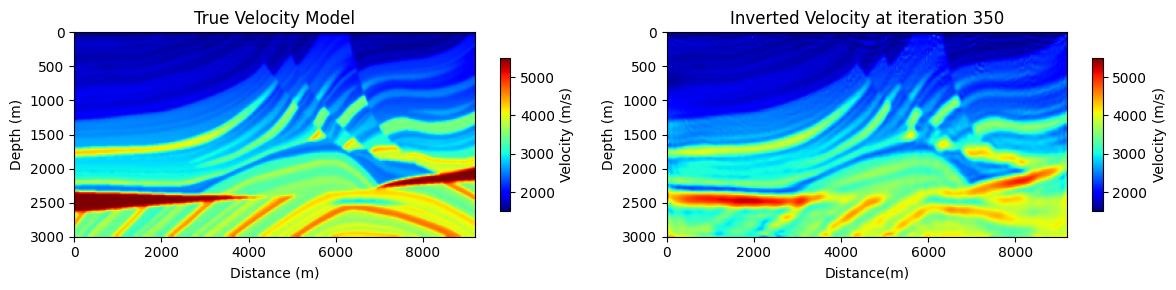

Epoch 351: loss=0.00068, v_min=1480.0, v_max=5275.9
Epoch 352: loss=0.00068, v_min=1480.0, v_max=5276.3
Epoch 353: loss=0.00068, v_min=1480.0, v_max=5276.7
Epoch 354: loss=0.00068, v_min=1480.0, v_max=5277.1
Epoch 355: loss=0.00068, v_min=1480.0, v_max=5277.5
Epoch 356: loss=0.00068, v_min=1480.0, v_max=5277.9
Epoch 357: loss=0.00068, v_min=1480.0, v_max=5278.3
Epoch 358: loss=0.00067, v_min=1480.0, v_max=5278.7
Epoch 359: loss=0.00067, v_min=1480.0, v_max=5279.1
Epoch 360: loss=0.00067, v_min=1480.0, v_max=5279.5
Epoch 361: loss=0.00067, v_min=1480.0, v_max=5279.9
Epoch 362: loss=0.00067, v_min=1480.0, v_max=5280.3
Epoch 363: loss=0.00067, v_min=1480.0, v_max=5280.7
Epoch 364: loss=0.00066, v_min=1480.0, v_max=5281.2
Epoch 365: loss=0.00066, v_min=1480.0, v_max=5281.6
Epoch 366: loss=0.00066, v_min=1480.0, v_max=5282.0
Epoch 367: loss=0.00066, v_min=1480.0, v_max=5282.4
Epoch 368: loss=0.00066, v_min=1480.0, v_max=5282.8
Epoch 369: loss=0.00066, v_min=1480.0, v_max=5283.2
Epoch 370: l

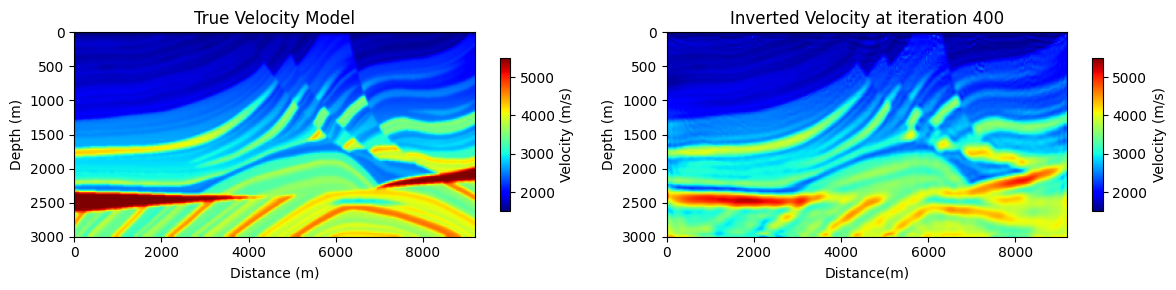

Epoch 401: loss=0.00062, v_min=1480.0, v_max=5295.6
Epoch 402: loss=0.00061, v_min=1480.0, v_max=5296.0
Epoch 403: loss=0.00061, v_min=1480.0, v_max=5296.3
Epoch 404: loss=0.00061, v_min=1480.0, v_max=5296.7
Epoch 405: loss=0.00061, v_min=1480.0, v_max=5297.1
Epoch 406: loss=0.00061, v_min=1480.0, v_max=5297.5
Epoch 407: loss=0.00061, v_min=1480.0, v_max=5297.8
Epoch 408: loss=0.00061, v_min=1480.0, v_max=5298.2
Epoch 409: loss=0.00061, v_min=1480.0, v_max=5298.6
Epoch 410: loss=0.00061, v_min=1480.0, v_max=5299.0
Epoch 411: loss=0.00060, v_min=1480.0, v_max=5299.3
Epoch 412: loss=0.00060, v_min=1480.0, v_max=5299.7
Epoch 413: loss=0.00060, v_min=1480.0, v_max=5300.1
Epoch 414: loss=0.00060, v_min=1480.0, v_max=5300.4
Epoch 415: loss=0.00060, v_min=1480.0, v_max=5300.8
Epoch 416: loss=0.00060, v_min=1480.0, v_max=5301.2
Epoch 417: loss=0.00060, v_min=1480.0, v_max=5301.6
Epoch 418: loss=0.00060, v_min=1480.0, v_max=5301.9
Epoch 419: loss=0.00059, v_min=1480.0, v_max=5302.3
Epoch 420: l

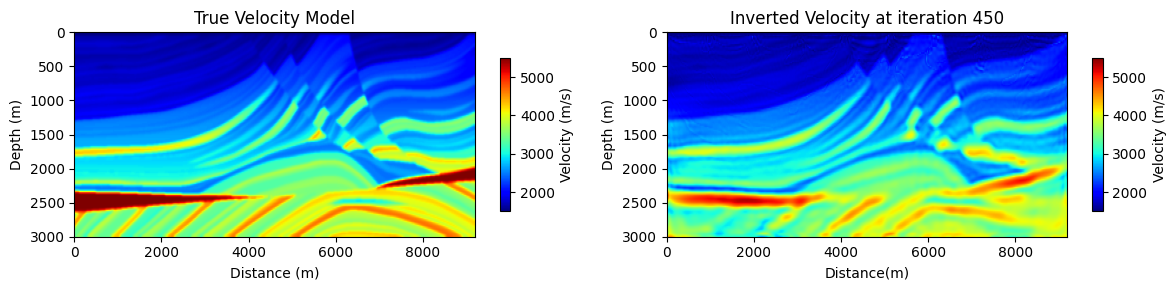

Epoch 451: loss=0.00056, v_min=1480.0, v_max=5314.0
Epoch 452: loss=0.00056, v_min=1480.0, v_max=5314.3
Epoch 453: loss=0.00056, v_min=1480.0, v_max=5314.7
Epoch 454: loss=0.00056, v_min=1480.0, v_max=5315.0
Epoch 455: loss=0.00056, v_min=1480.0, v_max=5315.4
Epoch 456: loss=0.00055, v_min=1480.0, v_max=5315.7
Epoch 457: loss=0.00055, v_min=1480.0, v_max=5316.1
Epoch 458: loss=0.00055, v_min=1480.0, v_max=5316.4
Epoch 459: loss=0.00055, v_min=1480.0, v_max=5316.8
Epoch 460: loss=0.00055, v_min=1480.0, v_max=5317.1
Epoch 461: loss=0.00055, v_min=1480.0, v_max=5317.5
Epoch 462: loss=0.00055, v_min=1480.0, v_max=5317.8
Epoch 463: loss=0.00055, v_min=1480.0, v_max=5318.2
Epoch 464: loss=0.00055, v_min=1480.0, v_max=5318.5
Epoch 465: loss=0.00055, v_min=1480.0, v_max=5318.9
Epoch 466: loss=0.00055, v_min=1480.0, v_max=5319.2
Epoch 467: loss=0.00054, v_min=1480.0, v_max=5319.6
Epoch 468: loss=0.00054, v_min=1480.0, v_max=5319.9
Epoch 469: loss=0.00054, v_min=1480.0, v_max=5320.3
Epoch 470: l

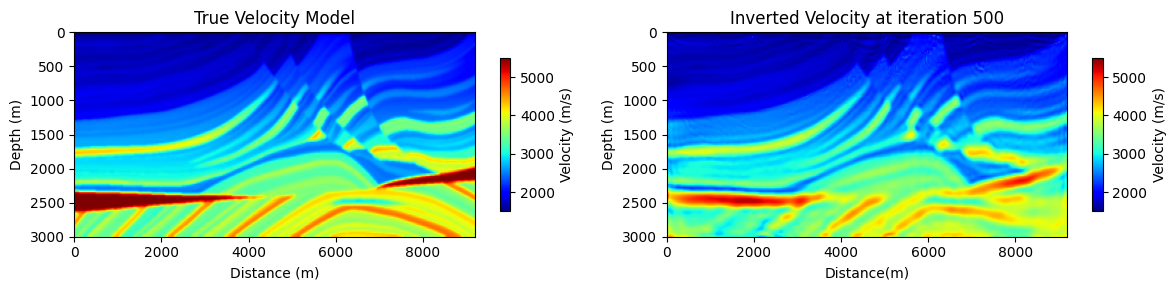

Epoch 501: loss=0.00051, v_min=1480.0, v_max=5331.1
Epoch 502: loss=0.00051, v_min=1480.0, v_max=5331.4
Epoch 503: loss=0.00051, v_min=1480.0, v_max=5331.8
Epoch 504: loss=0.00051, v_min=1480.0, v_max=5332.1
Epoch 505: loss=0.00051, v_min=1480.0, v_max=5332.4
Epoch 506: loss=0.00051, v_min=1480.0, v_max=5332.7
Epoch 507: loss=0.00051, v_min=1480.0, v_max=5333.1
Epoch 508: loss=0.00051, v_min=1480.0, v_max=5333.4
Epoch 509: loss=0.00051, v_min=1480.0, v_max=5333.7
Epoch 510: loss=0.00051, v_min=1480.0, v_max=5334.0
Epoch 511: loss=0.00050, v_min=1480.0, v_max=5334.4
Epoch 512: loss=0.00050, v_min=1480.0, v_max=5334.7
Epoch 513: loss=0.00050, v_min=1480.0, v_max=5335.0
Epoch 514: loss=0.00050, v_min=1480.0, v_max=5335.3
Epoch 515: loss=0.00050, v_min=1480.0, v_max=5335.7
Epoch 516: loss=0.00050, v_min=1480.0, v_max=5336.0
Epoch 517: loss=0.00050, v_min=1480.0, v_max=5336.3
Epoch 518: loss=0.00050, v_min=1480.0, v_max=5336.6
Epoch 519: loss=0.00050, v_min=1480.0, v_max=5337.0
Epoch 520: l

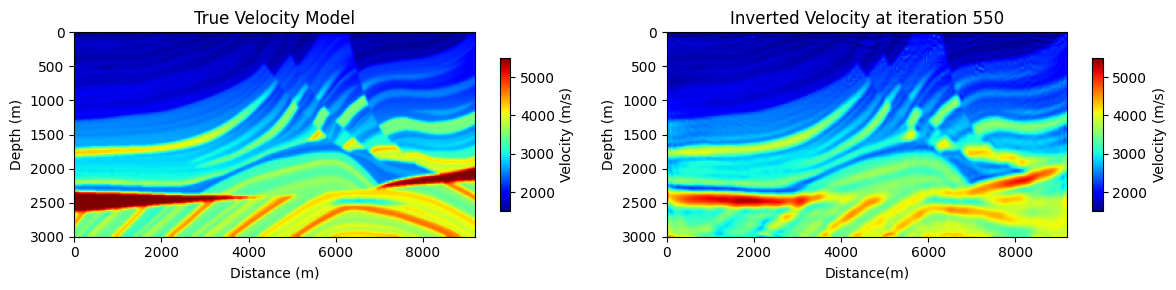

Epoch 551: loss=0.00047, v_min=1480.0, v_max=5347.2
Epoch 552: loss=0.00047, v_min=1480.0, v_max=5347.5
Epoch 553: loss=0.00047, v_min=1480.0, v_max=5347.8
Epoch 554: loss=0.00047, v_min=1480.0, v_max=5348.2
Epoch 555: loss=0.00047, v_min=1480.0, v_max=5348.5
Epoch 556: loss=0.00047, v_min=1480.0, v_max=5348.8
Epoch 557: loss=0.00047, v_min=1480.0, v_max=5349.1
Epoch 558: loss=0.00047, v_min=1480.0, v_max=5349.4
Epoch 559: loss=0.00047, v_min=1480.0, v_max=5349.7
Epoch 560: loss=0.00047, v_min=1480.0, v_max=5350.0
Epoch 561: loss=0.00047, v_min=1480.0, v_max=5350.3
Epoch 562: loss=0.00046, v_min=1480.0, v_max=5350.6
Epoch 563: loss=0.00046, v_min=1480.0, v_max=5350.9
Epoch 564: loss=0.00046, v_min=1480.0, v_max=5351.3
Epoch 565: loss=0.00046, v_min=1480.0, v_max=5351.6
Epoch 566: loss=0.00046, v_min=1480.0, v_max=5351.9
Epoch 567: loss=0.00046, v_min=1480.0, v_max=5352.2
Epoch 568: loss=0.00046, v_min=1480.0, v_max=5352.5
Epoch 569: loss=0.00046, v_min=1480.0, v_max=5352.8
Epoch 570: l

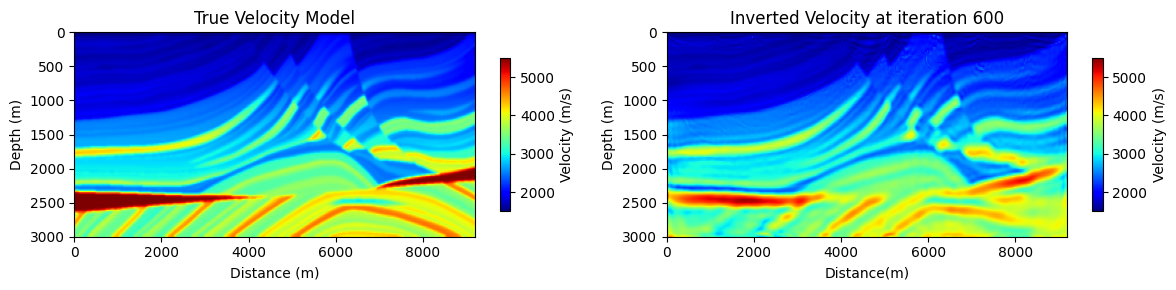

Epoch 601: loss=0.00044, v_min=1480.0, v_max=5362.3
Epoch 602: loss=0.00044, v_min=1480.0, v_max=5362.6
Epoch 603: loss=0.00044, v_min=1480.0, v_max=5362.9
Epoch 604: loss=0.00044, v_min=1480.0, v_max=5363.2
Epoch 605: loss=0.00044, v_min=1480.0, v_max=5363.5
Epoch 606: loss=0.00044, v_min=1480.0, v_max=5363.8
Epoch 607: loss=0.00043, v_min=1480.0, v_max=5364.1
Epoch 608: loss=0.00043, v_min=1480.0, v_max=5364.4
Epoch 609: loss=0.00043, v_min=1480.0, v_max=5364.7
Epoch 610: loss=0.00043, v_min=1480.0, v_max=5365.0
Epoch 611: loss=0.00043, v_min=1480.0, v_max=5365.2
Epoch 612: loss=0.00043, v_min=1480.0, v_max=5365.5
Epoch 613: loss=0.00043, v_min=1480.0, v_max=5365.8
Epoch 614: loss=0.00043, v_min=1480.0, v_max=5366.1
Epoch 615: loss=0.00043, v_min=1480.0, v_max=5366.4
Epoch 616: loss=0.00043, v_min=1480.0, v_max=5366.7
Epoch 617: loss=0.00043, v_min=1480.0, v_max=5367.0
Epoch 618: loss=0.00043, v_min=1480.0, v_max=5367.3
Epoch 619: loss=0.00043, v_min=1480.0, v_max=5367.6
Epoch 620: l

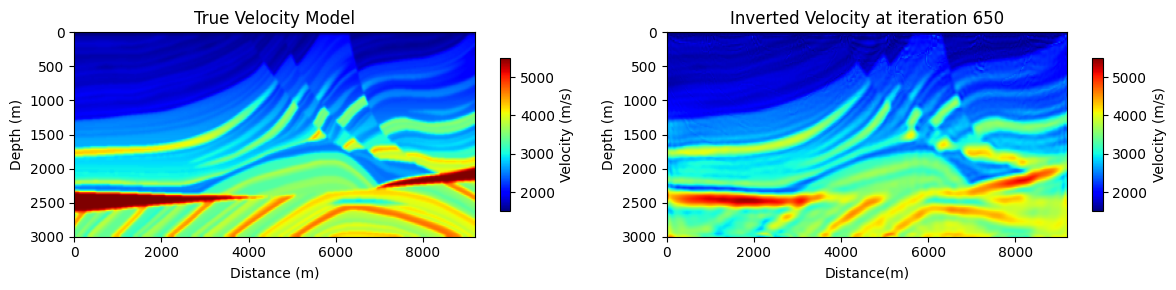

Epoch 651: loss=0.00041, v_min=1480.0, v_max=5376.7
Epoch 652: loss=0.00041, v_min=1480.0, v_max=5377.0
Epoch 653: loss=0.00041, v_min=1480.0, v_max=5377.3
Epoch 654: loss=0.00041, v_min=1480.0, v_max=5377.5
Epoch 655: loss=0.00041, v_min=1480.0, v_max=5377.8
Epoch 656: loss=0.00041, v_min=1480.0, v_max=5378.1
Epoch 657: loss=0.00040, v_min=1480.0, v_max=5378.4
Epoch 658: loss=0.00040, v_min=1480.0, v_max=5378.7
Epoch 659: loss=0.00040, v_min=1480.0, v_max=5378.9
Epoch 660: loss=0.00040, v_min=1480.0, v_max=5379.2
Epoch 661: loss=0.00040, v_min=1480.0, v_max=5379.5
Epoch 662: loss=0.00040, v_min=1480.0, v_max=5379.8
Epoch 663: loss=0.00040, v_min=1480.0, v_max=5380.0
Epoch 664: loss=0.00040, v_min=1480.0, v_max=5380.3
Epoch 665: loss=0.00040, v_min=1480.0, v_max=5380.6
Epoch 666: loss=0.00040, v_min=1480.0, v_max=5380.9
Epoch 667: loss=0.00040, v_min=1480.0, v_max=5381.1
Epoch 668: loss=0.00040, v_min=1480.0, v_max=5381.4
Epoch 669: loss=0.00040, v_min=1480.0, v_max=5381.7
Epoch 670: l

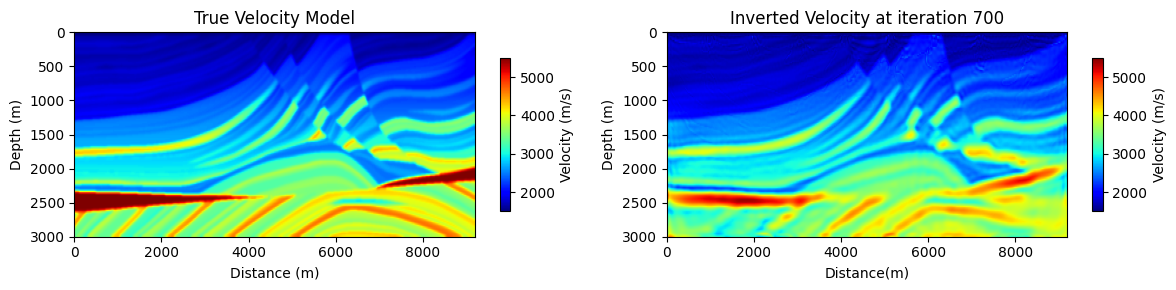

Epoch 701: loss=0.00038, v_min=1480.0, v_max=5390.8
Epoch 702: loss=0.00038, v_min=1480.0, v_max=5391.0
Epoch 703: loss=0.00038, v_min=1480.0, v_max=5391.3
Epoch 704: loss=0.00038, v_min=1480.0, v_max=5391.6
Epoch 705: loss=0.00038, v_min=1480.0, v_max=5391.9
Epoch 706: loss=0.00038, v_min=1480.0, v_max=5392.2
Epoch 707: loss=0.00038, v_min=1480.0, v_max=5392.5
Epoch 708: loss=0.00038, v_min=1480.0, v_max=5392.7
Epoch 709: loss=0.00038, v_min=1480.0, v_max=5393.0
Epoch 710: loss=0.00038, v_min=1480.0, v_max=5393.3
Epoch 711: loss=0.00038, v_min=1480.0, v_max=5393.6
Epoch 712: loss=0.00038, v_min=1480.0, v_max=5393.9
Epoch 713: loss=0.00038, v_min=1480.0, v_max=5394.1
Epoch 714: loss=0.00037, v_min=1480.0, v_max=5394.4
Epoch 715: loss=0.00037, v_min=1480.0, v_max=5394.7
Epoch 716: loss=0.00037, v_min=1480.0, v_max=5395.0
Epoch 717: loss=0.00037, v_min=1480.0, v_max=5395.2
Epoch 718: loss=0.00037, v_min=1480.0, v_max=5395.5
Epoch 719: loss=0.00037, v_min=1480.0, v_max=5395.8
Epoch 720: l

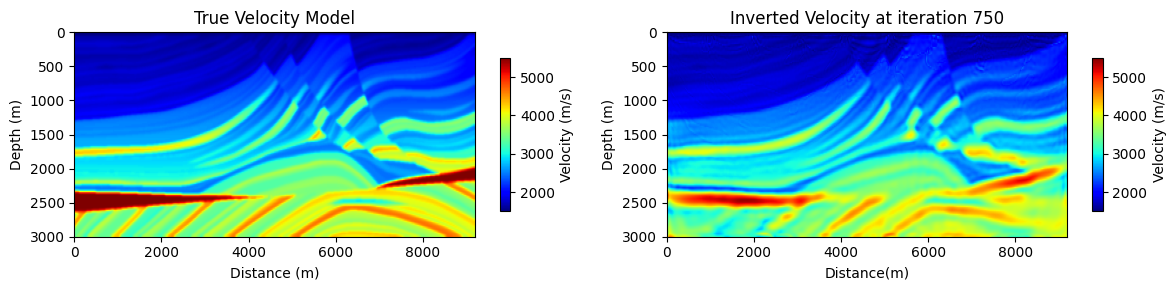

Epoch 751: loss=0.00036, v_min=1480.0, v_max=5404.6
Epoch 752: loss=0.00036, v_min=1480.0, v_max=5404.8
Epoch 753: loss=0.00036, v_min=1480.0, v_max=5405.1
Epoch 754: loss=0.00036, v_min=1480.0, v_max=5405.4
Epoch 755: loss=0.00036, v_min=1480.0, v_max=5405.6
Epoch 756: loss=0.00036, v_min=1480.0, v_max=5405.9
Epoch 757: loss=0.00035, v_min=1480.0, v_max=5406.2
Epoch 758: loss=0.00035, v_min=1480.0, v_max=5406.5
Epoch 759: loss=0.00035, v_min=1480.0, v_max=5406.7
Epoch 760: loss=0.00035, v_min=1480.0, v_max=5407.0
Epoch 761: loss=0.00035, v_min=1480.0, v_max=5407.3
Epoch 762: loss=0.00035, v_min=1480.0, v_max=5407.5
Epoch 763: loss=0.00035, v_min=1480.0, v_max=5407.8
Epoch 764: loss=0.00035, v_min=1480.0, v_max=5408.1
Epoch 765: loss=0.00035, v_min=1480.0, v_max=5408.3
Epoch 766: loss=0.00035, v_min=1480.0, v_max=5408.6
Epoch 767: loss=0.00035, v_min=1480.0, v_max=5408.9
Epoch 768: loss=0.00035, v_min=1480.0, v_max=5409.1
Epoch 769: loss=0.00035, v_min=1480.0, v_max=5409.4
Epoch 770: l

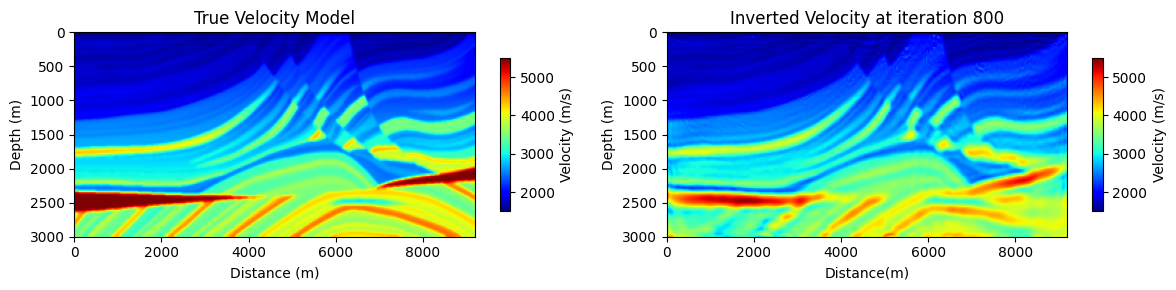

In [8]:
## INVERSION

# We track the gradient of the velocity
v1.requires_grad_()

# Velocity limits used for plotting
vmin = v_true.min()
vmax = v_true.max()

n_epochs = 800    # Total number of iterations
optimiser = torch.optim.Adam([v1], lr=1e2)             # Adam optimizer with large initial lr to speed early convergence
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimiser, milestones=[75, 300],  gamma=0.5        # Halve lr at epochs 75 and 300 to stabilize updates
    )


# OPTIMIZATION LOOP
losses = []
gradients = []

for epoch in range(n_epochs):
    optimiser.zero_grad()   # Initialize the gradient
    out_pred = scalar( v1, spacing, dt,                     # Computation of the synthetic data
                        source_amplitudes=source_amp,
                        source_locations=source_loc,
                        receiver_locations=receiver_loc,
                        accuracy=4,
                        pml_freq= freq
                    )
    pred_data = out_pred[-1]
    loss = loss_fn(taper(pred_data, n_taper=5), observed_data_tapered)  # Misfit
    loss.backward()               # gradient computation

    # Gradient post-processing (smoothing + clipping extreme values)
    with torch.no_grad():
        grad = v1.grad.detach().cpu().numpy()
        grad_smoothed = gaussian_filter(grad, sigma=1)      # Smoothing
        v1.grad.copy_(torch.tensor(grad_smoothed).to(device))

        clip_value = torch.quantile(v1.grad.abs(), 0.98)
        torch.nn.utils.clip_grad_value_([v1], clip_value)   # Cliiping

    optimiser.step()   # Update
    scheduler.step()

    # Enforce physical bounds on velocity to prevent divergence
    with torch.no_grad():
        v1.clamp_(min=1480.0, max=5800.0)

    losses.append(loss.item())      # store the losses
    gradients.append(v1.grad.clone().detach().cpu())   # store the gradients

    # Print info
    print(f"Epoch {epoch+1}: loss={loss.item():.5f}, v_min={v1.min().item():.1f}, v_max={v1.max().item():.1f}")

    # Visualise evolution of the inversion
    if (epoch+1) % 50 == 0:

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

        # Plot 1: True Velocity
        im1 = ax1.imshow(v_true.cpu().T, vmin=vmin, vmax=vmax, cmap='jet',
                   aspect='auto', extent=extent)
        ax1.set_title(f'True Velocity Model')
        ax1.set_xlabel("Distance (m)")
        ax1.set_ylabel("Depth (m)")

        # Plot 2: Inverted Velocity
        im2 = ax2.imshow(v1.detach().cpu().T, vmin=vmin, vmax=vmax, cmap='jet',
                        aspect='auto', extent=extent)
        ax2.set_title(f'Inverted Velocity at iteration {epoch+1}')
        ax2.set_xlabel("Distance(m)")
        ax2.set_ylabel("Depth (m)")

        fig.colorbar(im1, ax=ax1, label='Velocity (m/s)',
                     shrink=0.75, aspect=15, pad=0.05)
        fig.colorbar(im2, ax=ax2, label='Velocity (m/s)',
                     shrink=0.75, aspect=15, pad=0.05)

        plt.tight_layout()
        plt.show()


In [9]:
# FINAL PREDICTED DATA
with torch.no_grad():
    out_final = scalar(
        v1, spacing, dt,
        source_amplitudes=source_amp,
        source_locations=source_loc,
        receiver_locations=receiver_loc,
        accuracy=4,
        pml_freq=freq,
    )
predicted_data = out_final[-1]

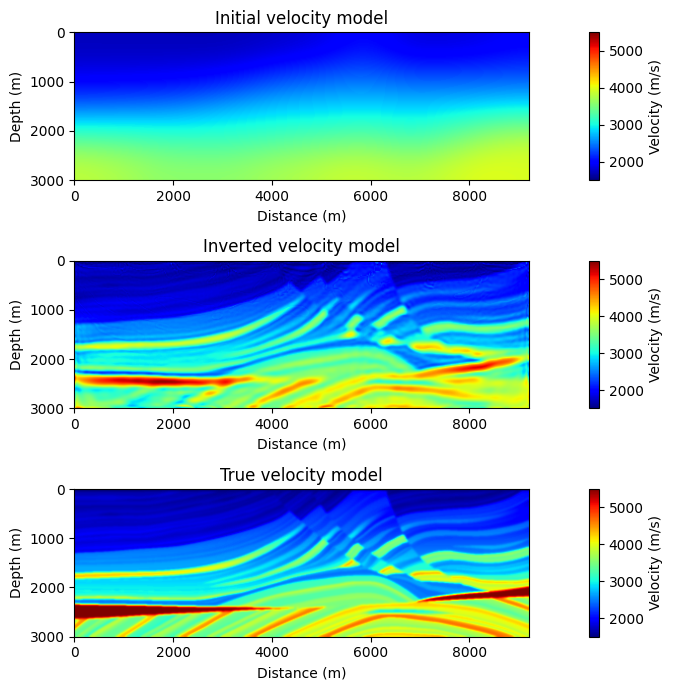

In [10]:
# PLOTTING THE RESULTS OF THE LOCAL INVERSION

fig1, ax1 = plt.subplots(3, figsize=(7, 7))
im0 = ax1[0].imshow(v_init.cpu().T, aspect='auto', cmap='jet',
             vmin= vmin, vmax=vmax, extent=extent)
ax1[0].set_title("Initial velocity model")
ax1[0].set_xlabel("Distance (m)")
ax1[0].set_ylabel("Depth (m)")
fig1.colorbar(im0, ax = ax1[0], shrink = 1, aspect = 15, pad = 0.1, label='Velocity (m/s)' )

im1 = ax1[1].imshow(v1.detach().cpu().T, aspect='auto', cmap='jet',
             vmin= vmin, vmax=vmax, extent=extent)
ax1[1].set_title(f"Inverted velocity model")
ax1[1].set_xlabel("Distance (m)")
ax1[1].set_ylabel("Depth (m)")
fig1.colorbar(im1, ax = ax1[1], shrink = 1, aspect = 15, pad = 0.1, label='Velocity (m/s)' )

im2 = ax1[2].imshow(v_true.cpu().T, aspect='auto', cmap='jet',
             vmin= vmin, vmax=vmax, extent=extent)
ax1[2].set_title("True velocity model")
ax1[2].set_xlabel("Distance (m)")
ax1[2].set_ylabel("Depth (m)")
fig1.colorbar(im2, ax = ax1[2], shrink = 1, aspect = 15, pad = 0.1, label='Velocity (m/s)' )

plt.tight_layout()
#plt.savefig("result_fwi_marmousi.png", dpi=300)  # uncomment to save the result


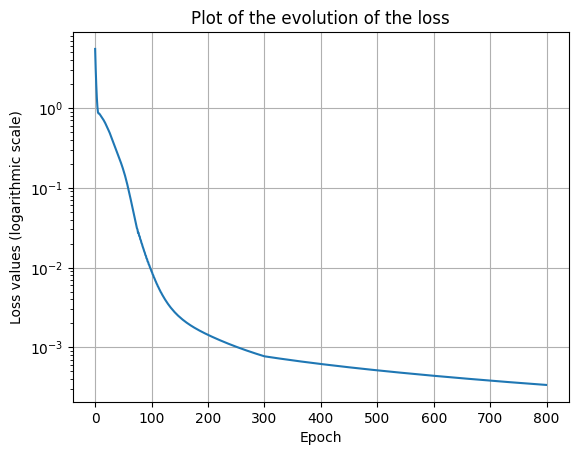

In [11]:
#PLOT THE LOSS VALUES
plt.figure()
plt.plot(losses)
plt.yscale('log')
plt.title("Plot of the evolution of the loss")
plt.xlabel("Epoch")
plt.ylabel("Loss values (logarithmic scale)")
plt.grid()
plt.show()


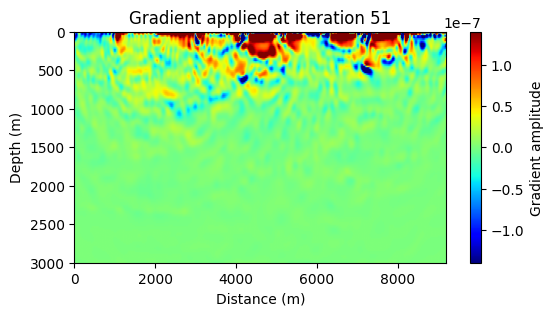

In [12]:
#PLOT OF THE GRADIENTS
k = 50                     # Select iteration index to plot the corresponding gradient
plt.figure(figsize=(6, 3))
plt.imshow(gradients[k].cpu().T, cmap='jet', aspect='auto', extent=extent)
plt.title(f"Gradient applied at iteration {k+1}")
plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.colorbar(label='Gradient amplitude')
plt.show()

Shot 1: MSE=5.865e-04, RMS=2.422e-02, RelL2=1.008e-02


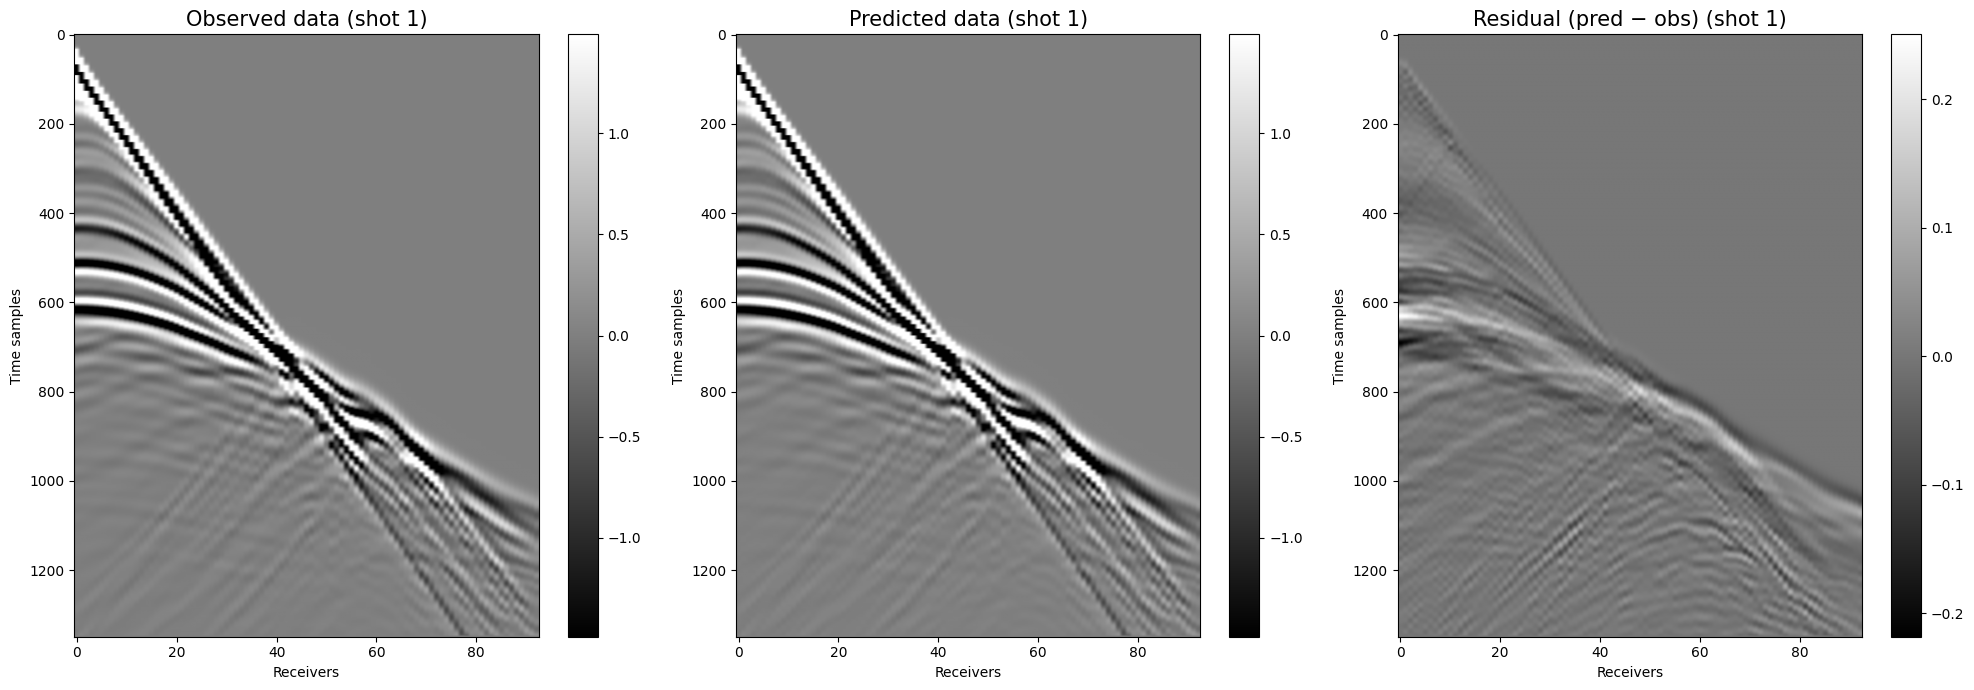

In [13]:
# PLOTS OF OBSERVED, PREDICTED AND RESIDUAL DATA
shot = 0   # Select the shot index to plot

# Observed and predicted data extracted at specific shot
obs  = observed_data_tapered[shot].detach().cpu()
pred = taper(predicted_data, n_taper = 5)[shot].detach().cpu()
res  = (pred - obs)  # residual

# Clip for observed and predicted data
amp = torch.quantile(obs.abs(), 0.95).item()

# Plot the data
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

im0 = axes[0].imshow(obs.T, aspect="auto", cmap="gray", vmin=-amp, vmax=amp)
axes[0].set_title(f"Observed data (shot {shot + 1})", fontsize = 15)
axes[0].set_xlabel("Receivers"); axes[0].set_ylabel("Time samples")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(pred.T, aspect="auto", cmap="gray", vmin=-amp, vmax=amp)
axes[1].set_title(f"Predicted data (shot {shot + 1})", fontsize = 15)
axes[1].set_xlabel("Receivers"); axes[1].set_ylabel("Time samples")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(res.T, aspect="auto", cmap="gray")
axes[2].set_title(f"Residual (pred − obs) (shot {shot + 1})", fontsize = 15)
axes[2].set_xlabel("Receivers"); axes[2].set_ylabel("Time samples")
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
#plt.savefig('all_data.png', dpi = 300, bbox_inches="tight")   # uncomment to save image


# SHOT-BY-SHOT ERROR METRICS
mse = torch.mean(res**2).item()                      # Mean square error
rms = torch.sqrt(torch.mean(res**2)).item()          # Root mean square error
rel = (torch.norm(res) / torch.norm(obs)).item()     # Relatve L2 error
print(f"Shot {shot+1}: MSE={mse:.3e}, RMS={rms:.3e}, RelL2={rel:.3e}")
